# EDA | Разведочный анализ данных

__TODO__:
- исследовать `num_b_length` по разным классам

- [Диаграммы с накоплением для таргета](#Диаграммы-с-накоплением-для-таргета)
- [Диаграммы с накоплением для фичей](#Диаграммы-с-накоплением-для-фичей)

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = os.path.join('data', 'transactions')
TARGET_PATH = os.path.join('data', 'beeline_antispam_hakaton_id_samples.csv')

COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:gray']

In [3]:
data_paths = [os.path.join(DATA_PATH, file_name) for file_name in os.listdir(DATA_PATH)]

targets = pd.read_csv(TARGET_PATH, dtype={
    'id': 'uint32',
    'target': 'float32',
    'split': 'category',
})
targets['target'] = (
    targets['target']
    .replace({
        0.: 'не спам',
        1.: 'небольшие полезные ИП / малые бизнесы',
        2.: 'организации',
        3.: 'мобильная карусель',
        4.: 'чёрные спаммеры и мошенники',
    })
    .astype('category')
)
targets.head()

,id,target,split
0,196535,NaN,test
1,63075900,организации,train
2,35233935,организации,train
3,23557360,чёрные спаммеры и мошенники,train
4,78926486,NaN,test


In [4]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46235 entries, 0 to 46234
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      46235 non-null  uint32  
 1   target  36942 non-null  category
 2   split   46235 non-null  category
dtypes: category(2), uint32(1)
memory usage: 271.3 KB


## Диаграммы с накоплением для таргета

In [5]:
interesting_groups = [
    'не спам',
    'небольшие полезные ИП / малые бизнесы',
    'организации',
    'мобильная карусель',
    'чёрные спамеры и мошенники',
    'test',
    'неразмеченные',
]

In [6]:
transactions_a = pd.DataFrame()
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = (
        # читаем `id_a`
        pd.read_csv(data_path, usecols=['id_a'], dtype={'id_a': 'uint32'})
        # добавляем `target_a` и `split_a` слиянием
        .merge(targets, left_on='id_a', right_on='id', how='left')
        .rename(columns={'target': 'target_a', 'split': 'split_a'})
        .drop(columns='id')
    )
    # распределения для отдельных транзакций по id_a    
    row = pd.DataFrame([[
        (call_transactions['target_a'] == 'не спам').sum(),
        (call_transactions['target_a'] == 'небольшие полезные ИП / малые бизнесы').sum(),
        (call_transactions['target_a'] == 'организации').sum(),
        (call_transactions['target_a'] == 'мобильная карусель').sum(),
        (call_transactions['target_a'] == 'чёрные спаммеры и мошенники').sum(),
        (call_transactions['split_a'] == 'test').sum(),
        call_transactions['split_a'].isna().sum(),
    ]],
        columns=interesting_groups,
        index=[date],
    )
    transactions_a = pd.concat([transactions_a, row])

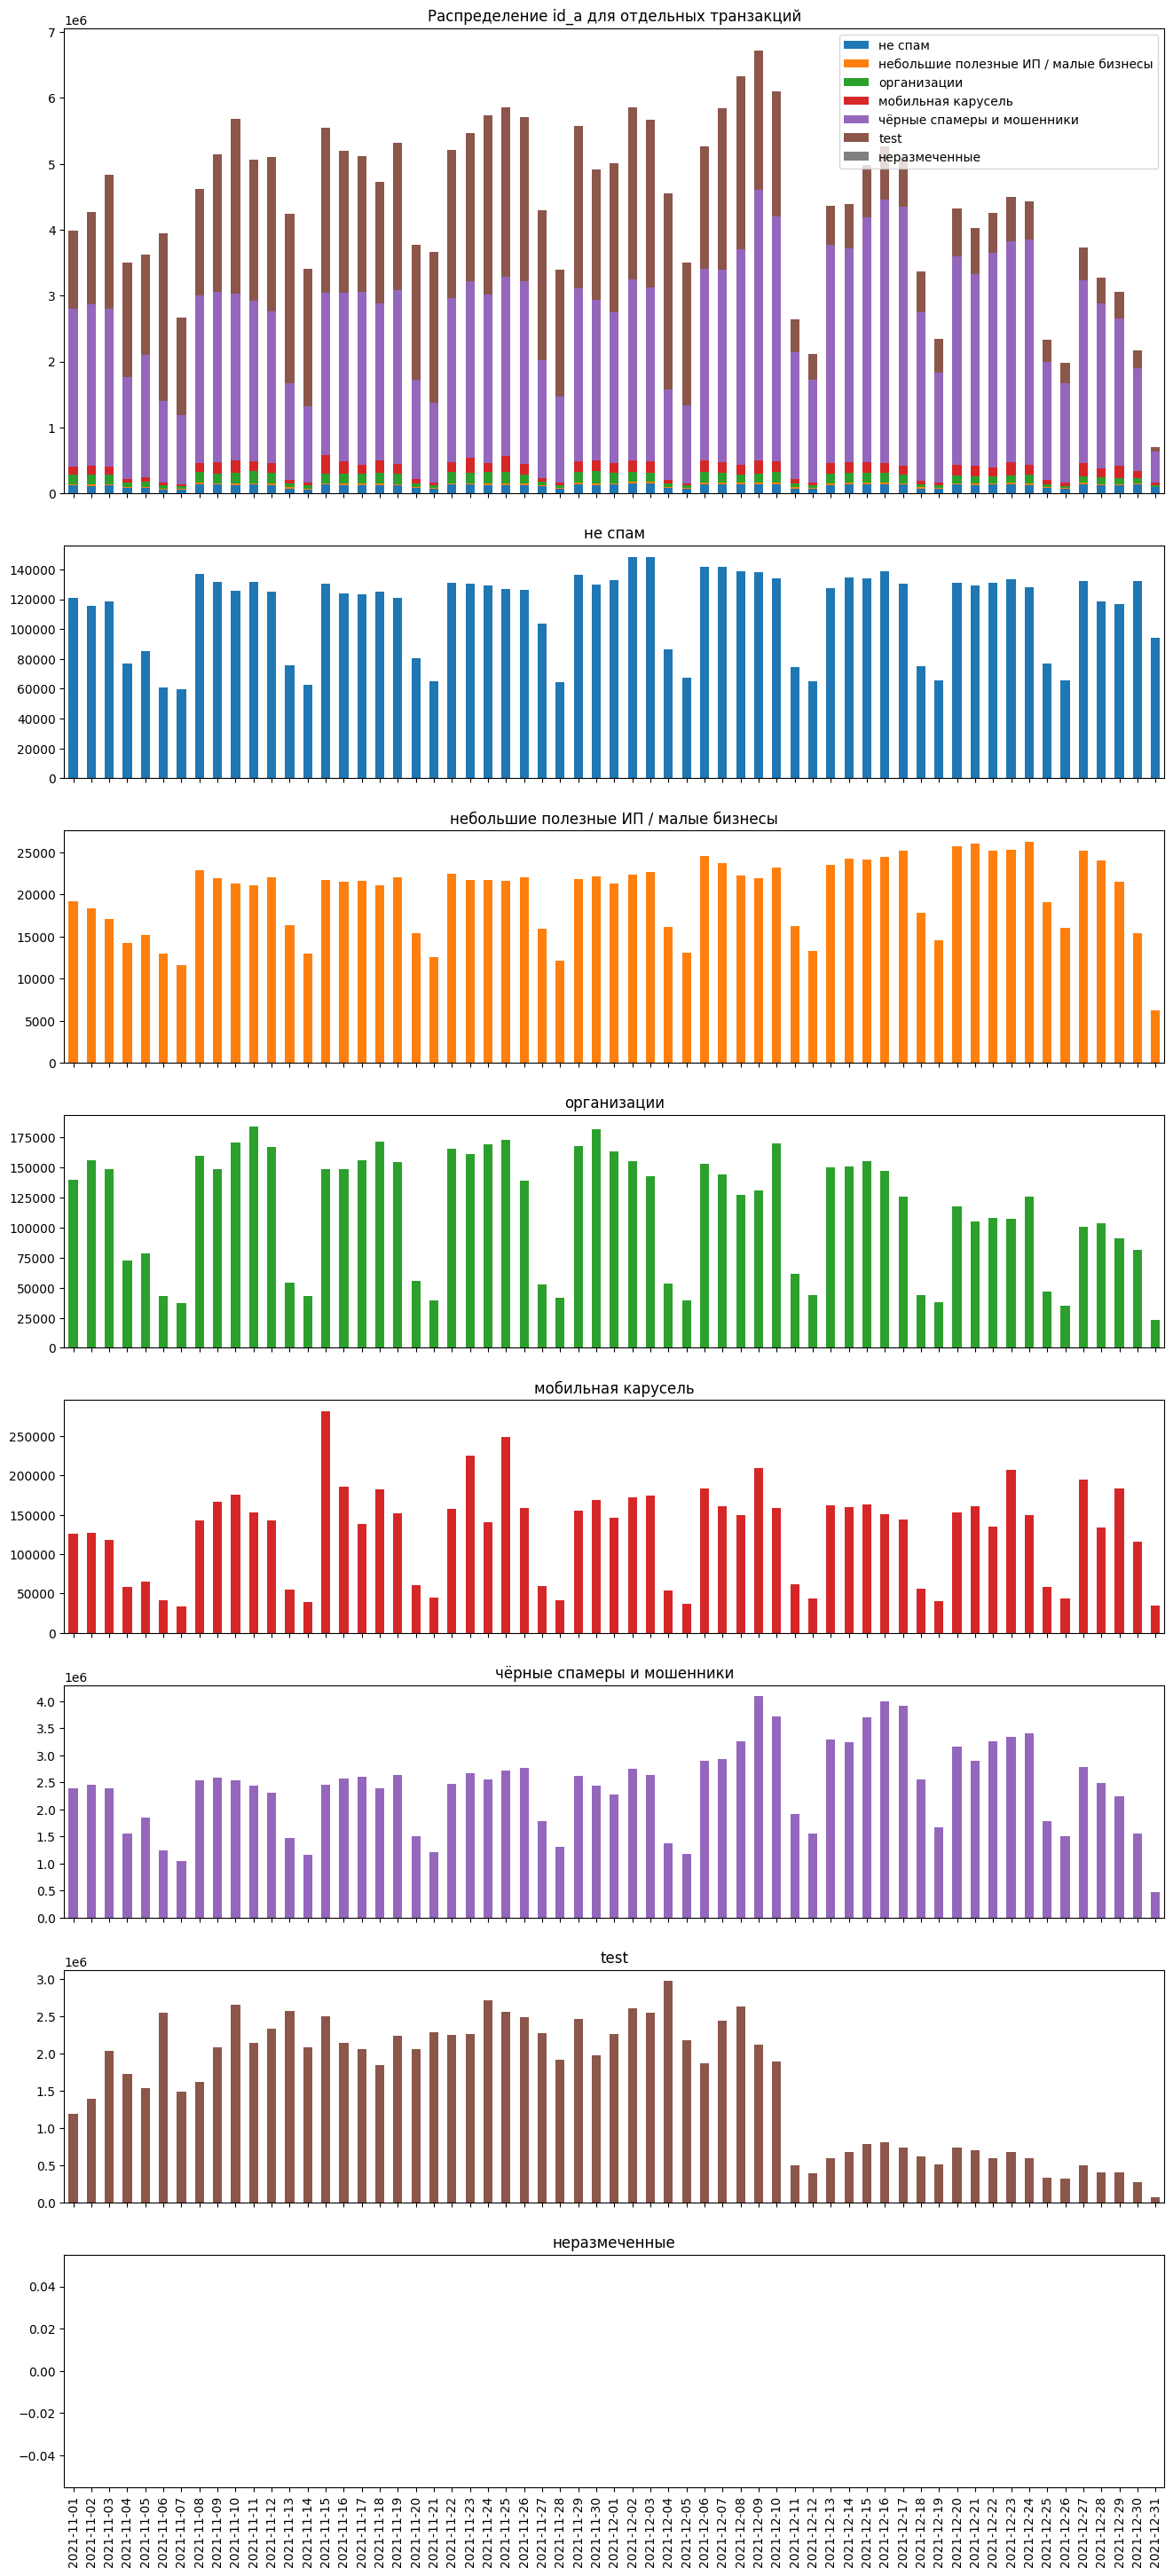

In [7]:
fig, axes = plt.subplots(8, 1, figsize=(16, 36), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1, 1, 1]}, sharex=True)

transactions_a.plot(
    kind='bar', stacked=True, ax=axes[0], color=COLORS[:7], title='Распределение id_a для отдельных транзакций')
transactions_a['не спам'].plot(kind='bar', ax=axes[1], color=COLORS[0], title='не спам')
transactions_a['небольшие полезные ИП / малые бизнесы'].plot(
    kind='bar', ax=axes[2], color=COLORS[1], title='небольшие полезные ИП / малые бизнесы')
transactions_a['организации'].plot(kind='bar', ax=axes[3], color=COLORS[2], title='организации')
transactions_a['мобильная карусель'].plot(kind='bar', ax=axes[4], color=COLORS[3], title='мобильная карусель')
transactions_a['чёрные спамеры и мошенники'].plot(
    kind='bar', ax=axes[5], color=COLORS[4], title='чёрные спамеры и мошенники')
transactions_a['test'].plot(kind='bar', ax=axes[6], color=COLORS[5], title='test')
transactions_a['неразмеченные'].plot(kind='bar', ax=axes[7], color=COLORS[6], title='неразмеченные')
axes[7].set_xticklabels(transactions_a.index.format())

plt.show()

E:\Projects\BestHack2022-DataScience\venv\lib\site-packages\calmap\__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
E:\Projects\BestHack2022-DataScience\venv\lib\site-packages\calmap\__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


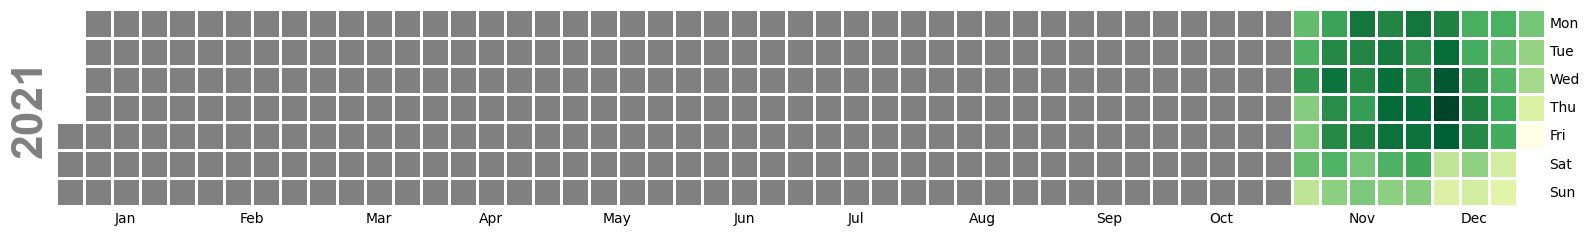

In [8]:
import calmap

# TODO: здесь не работают почему-то параметры `monthlabels` и `monthticks`
# может стоит залезть в исходный код
# https://pythonhosted.org/calmap/
# хотелось вывести только 2 необходимых месяца
_ = calmap.calendarplot(
    transactions_a.sum(axis=1),
    fig_kws={'figsize': (16, 10)},
    fillcolor='gray',
    cmap='YlGn',
)

In [9]:
transactions_b = pd.DataFrame()
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = (
        # читаем `id_b`
        pd.read_csv(data_path, usecols=['id_b'], dtype={'id_b': 'uint32'})
        # добавляем `target_b` и `split_b` слиянием
        .merge(targets, left_on='id_b', right_on='id', how='left')
        .rename(columns={'target': 'target_b', 'split': 'split_b'})
        .drop(columns='id')
    )
    # распределения для отдельных транзакций по id_b
    row = pd.DataFrame([[
        (call_transactions['target_b'] == 'не спам').sum(),
        (call_transactions['target_b'] == 'небольшие полезные ИП / малые бизнесы').sum(),
        (call_transactions['target_b'] == 'организации').sum(),
        (call_transactions['target_b'] == 'мобильная карусель').sum(),
        (call_transactions['target_b'] == 'чёрные спаммеры и мошенники').sum(),
        (call_transactions['split_b'] == 'test').sum(),
        call_transactions['split_b'].isna().sum(),
    ]],
        columns=interesting_groups,
        index=[date],
    )
    transactions_b = pd.concat([transactions_b, row])

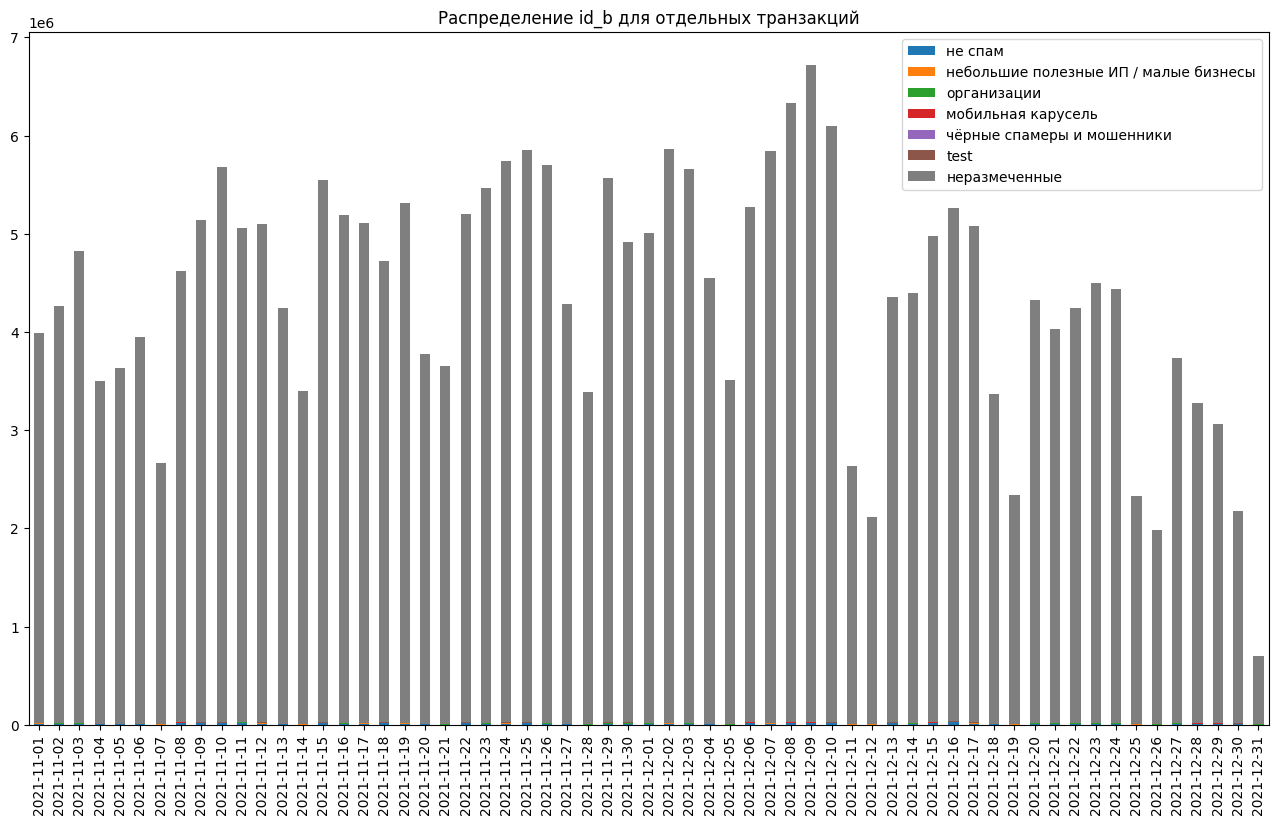

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))

transactions_b.plot(kind='bar', stacked=True, ax=ax, color=COLORS[:7], title='Распределение id_b для отдельных транзакций')
ax.set_xticklabels(transactions_b.index.format())

plt.show()

In [11]:
ids_a = pd.DataFrame()
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = (
        # читаем `id_a`
        pd.read_csv(data_path, usecols=['id_a'], dtype={'id_a': 'uint32'})
        # добавляем `target_a` и `split_a` слиянием
        .merge(targets, left_on='id_a', right_on='id', how='left')
        .rename(columns={'target': 'target_a', 'split': 'split_a'})
        .drop(columns='id')
    )
    # распределение уникальных id_a
    row = pd.DataFrame([[
        call_transactions.loc[call_transactions['target_a'] == 'не спам', 'id_a'].nunique(),
        call_transactions.loc[call_transactions['target_a'] == 'небольшие полезные ИП / малые бизнесы', 'id_a'].nunique(),
        call_transactions.loc[call_transactions['target_a'] == 'организации', 'id_a'].nunique(),
        call_transactions.loc[call_transactions['target_a'] == 'мобильная карусель', 'id_a'].nunique(),
        call_transactions.loc[call_transactions['target_a'] == 'чёрные спаммеры и мошенники', 'id_a'].nunique(),
        call_transactions.loc[call_transactions['split_a'] == 'test', 'id_a'].nunique(),
        call_transactions.loc[call_transactions['split_a'].isna(), 'id_a'].nunique(),
    ]],
        columns=[
            'не спам',
            'небольшие полезные ИП / малые бизнесы',
            'организации',
            'мобильная карусель',
            'чёрные спамеры и мошенники',
            'test',
            'неразмеченные',
        ],
        index=[date],
    )
    ids_a = pd.concat([ids_a, row])

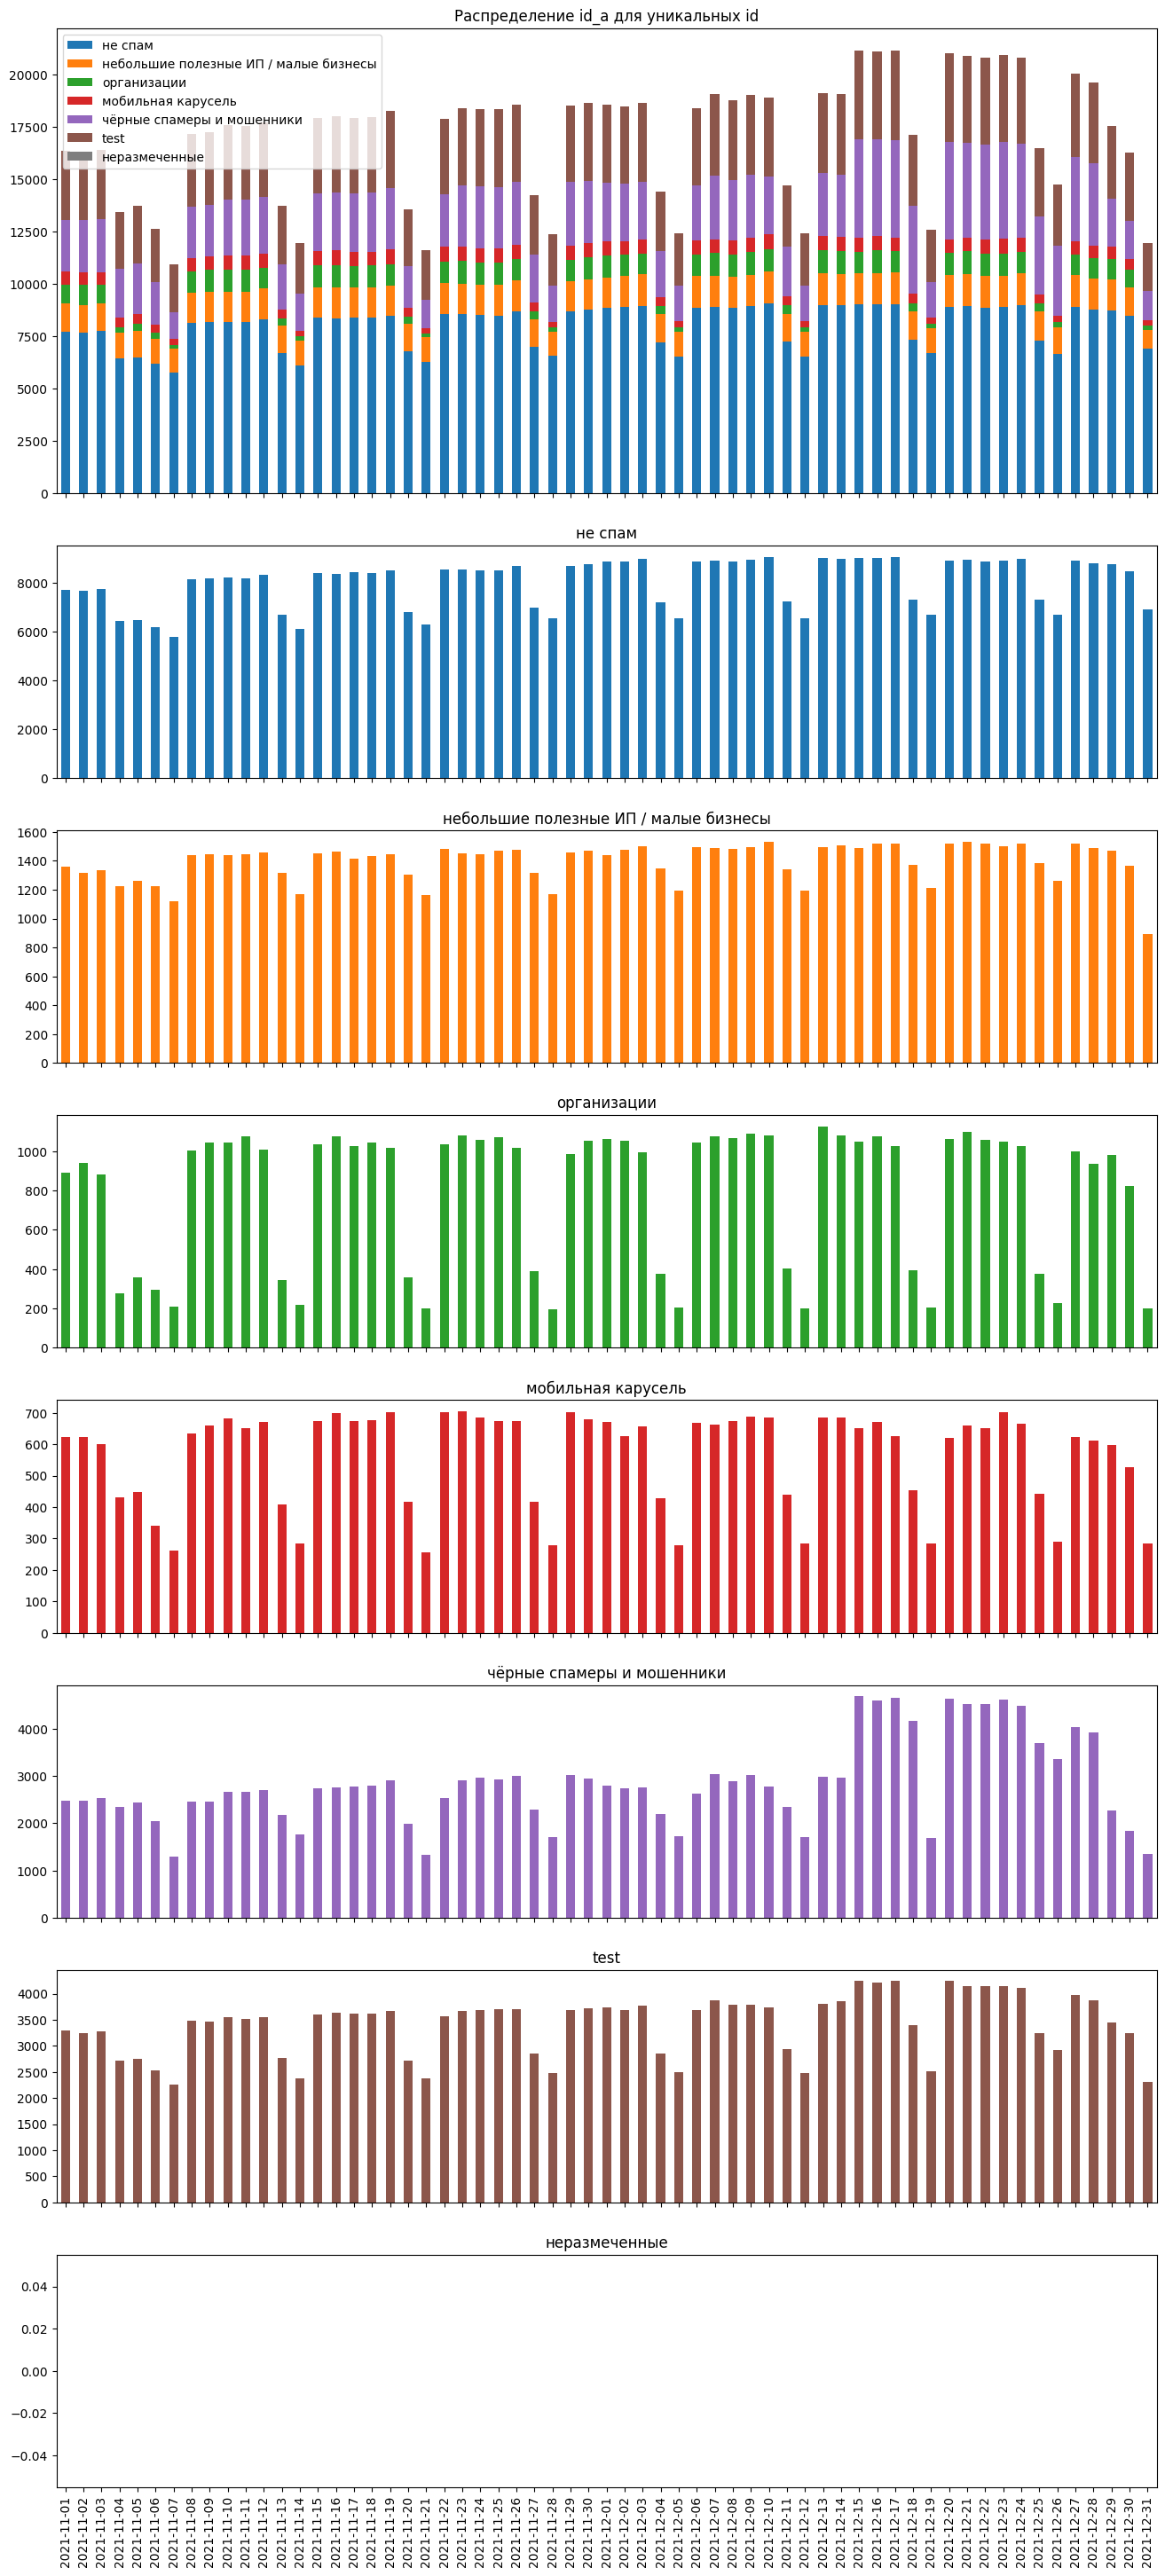

In [12]:
fig, axes = plt.subplots(8, 1, figsize=(16, 36), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1, 1, 1]}, sharex=True)

ids_a.plot(kind='bar', stacked=True, ax=axes[0], color=COLORS[:7], title='Распределение id_a для уникальных id')
ids_a['не спам'].plot(kind='bar', ax=axes[1], color=COLORS[0], title='не спам')
ids_a['небольшие полезные ИП / малые бизнесы'].plot(kind='bar', ax=axes[2], color=COLORS[1], title='небольшие полезные ИП / малые бизнесы')
ids_a['организации'].plot(kind='bar', ax=axes[3], color=COLORS[2], title='организации')
ids_a['мобильная карусель'].plot(kind='bar', ax=axes[4], color=COLORS[3], title='мобильная карусель')
ids_a['чёрные спамеры и мошенники'].plot(kind='bar', ax=axes[5], color=COLORS[4], title='чёрные спамеры и мошенники')
ids_a['test'].plot(kind='bar', ax=axes[6], color=COLORS[5], title='test')
ids_a['неразмеченные'].plot(kind='bar', ax=axes[7], color=COLORS[6], title='неразмеченные')
axes[7].set_xticklabels(ids_a.index.format())

plt.show()

In [13]:
ids_b = pd.DataFrame()
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = (
        # читаем `id_b`
        pd.read_csv(data_path, usecols=['id_b'], dtype={'id_b': 'uint32'})
        # добавляем `target_b` и `split_b` слиянием
        .merge(targets, left_on='id_b', right_on='id', how='left')
        .rename(columns={'target': 'target_b', 'split': 'split_b'})
        .drop(columns='id')
    )
    # распределение уникальных id_b
    row = pd.DataFrame([[
        call_transactions.loc[call_transactions['target_b'] == 'не спам', 'id_b'].nunique(),
        call_transactions.loc[call_transactions['target_b'] == 'небольшие полезные ИП / малые бизнесы', 'id_b'].nunique(),
        call_transactions.loc[call_transactions['target_b'] == 'организации', 'id_b'].nunique(),
        call_transactions.loc[call_transactions['target_b'] == 'мобильная карусель', 'id_b'].nunique(),
        call_transactions.loc[call_transactions['target_b'] == 'чёрные спаммеры и мошенники', 'id_b'].nunique(),
        call_transactions.loc[call_transactions['split_b'] == 'test', 'id_b'].nunique(),
        call_transactions.loc[call_transactions['split_b'].isna(), 'id_b'].nunique(),
    ]],
        columns=[
            'не спам',
            'небольшие полезные ИП / малые бизнесы',
            'организации',
            'мобильная карусель',
            'чёрные спамеры и мошенники',
            'test',
            'неразмеченные',
        ],
        index=[date],
    )
    ids_b = pd.concat([ids_b, row])

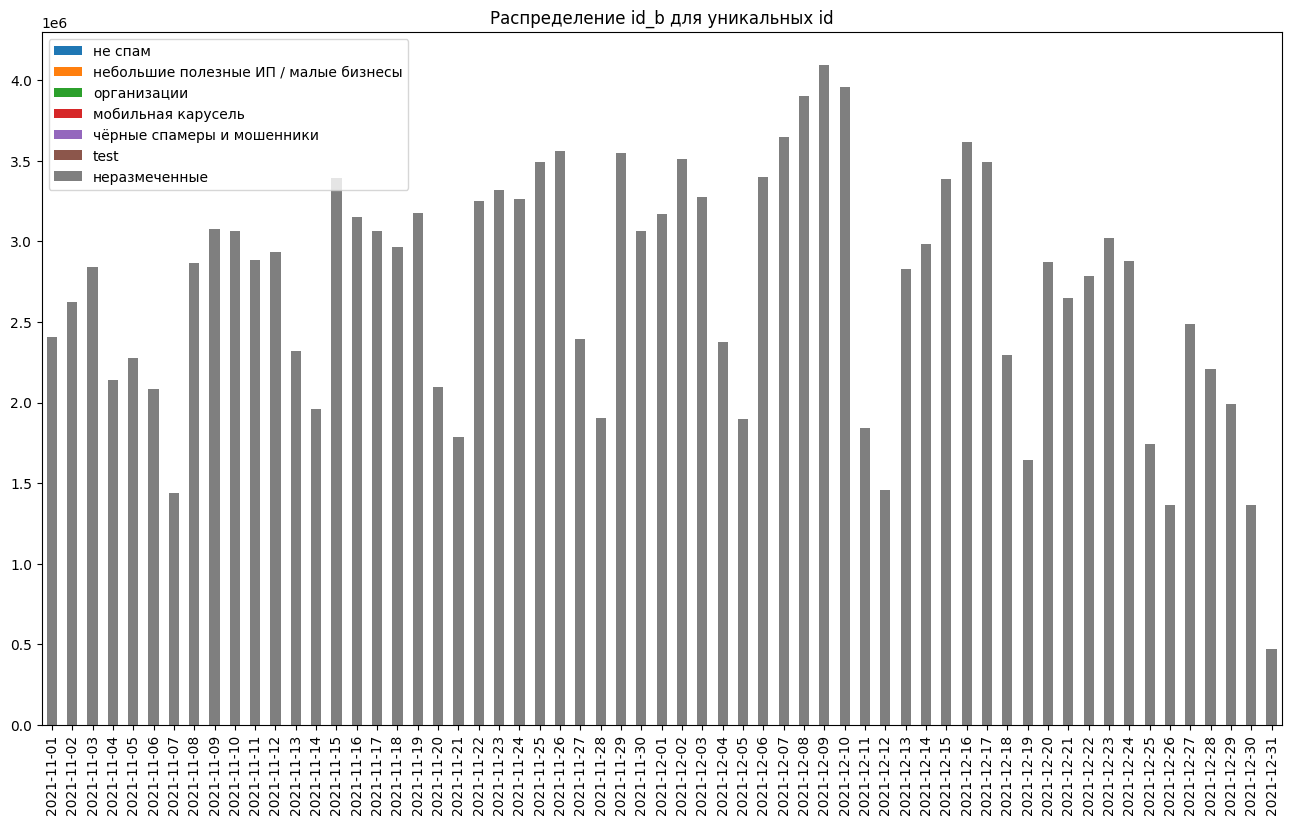

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))

ids_b.plot(kind='bar', stacked=True, ax=ax, color=COLORS[:7], title='Распределение id_b для уникальных id')
ax.set_xticklabels(ids_b.index.format())

plt.show()

**Вывод**: На `id_b` можно не смотреть как на таргет, так как там большинство неинтересующих нас id. Однако там мелькают размеченные.

## Диаграммы с накоплением для фичей

### start_time_local

In [52]:
a = pd.read_csv(
    os.path.join(DATA_PATH, 'time_key=2021-11-01.csv'),
    usecols=['id_a', 'id_b', 'start_time_local'],
    dtype={
        'id_a': 'uint32',
        'id_b': 'uint32',
    },
)

In [58]:
a['start_time_local'] = pd.to_timedelta(a['start_time_local'])
a['start_time_local_in_seconds'] =  a['start_time_local'].dt.seconds
a.head()

,id_a,id_b,start_time_local,start_time_local_in_seconds
0,67596082,43588153,0 days 18:43:03,67383
1,4024969,67656553,0 days 11:43:20,42200
2,43166780,31861625,0 days 10:32:36,37956
3,51817902,41201237,0 days 13:45:02,49502
4,41812796,4932754,0 days 13:53:12,49992


In [48]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987696 entries, 0 to 3987695
Data columns (total 4 columns):
 #   Column                       Dtype          
---  ------                       -----          
 0   id_a                         uint32         
 1   id_b                         uint32         
 2   start_time_local             timedelta64[ns]
 3   start_time_local_in_seconds  int64          
dtypes: int64(1), timedelta64[ns](1), uint32(2)
memory usage: 91.3 MB


### time_zone

In [79]:
tz = pd.DataFrame(index=[-1, 0, 1, 2, 3 , 4, 5, 6, 7, 8, 9, 10, 11, 12])
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = pd.read_csv(data_path, usecols=['time_zone'], dtype={'time_zone': 'uint32'})
    tz[date] = call_transactions['time_zone'].value_counts()
tz = tz.transpose()

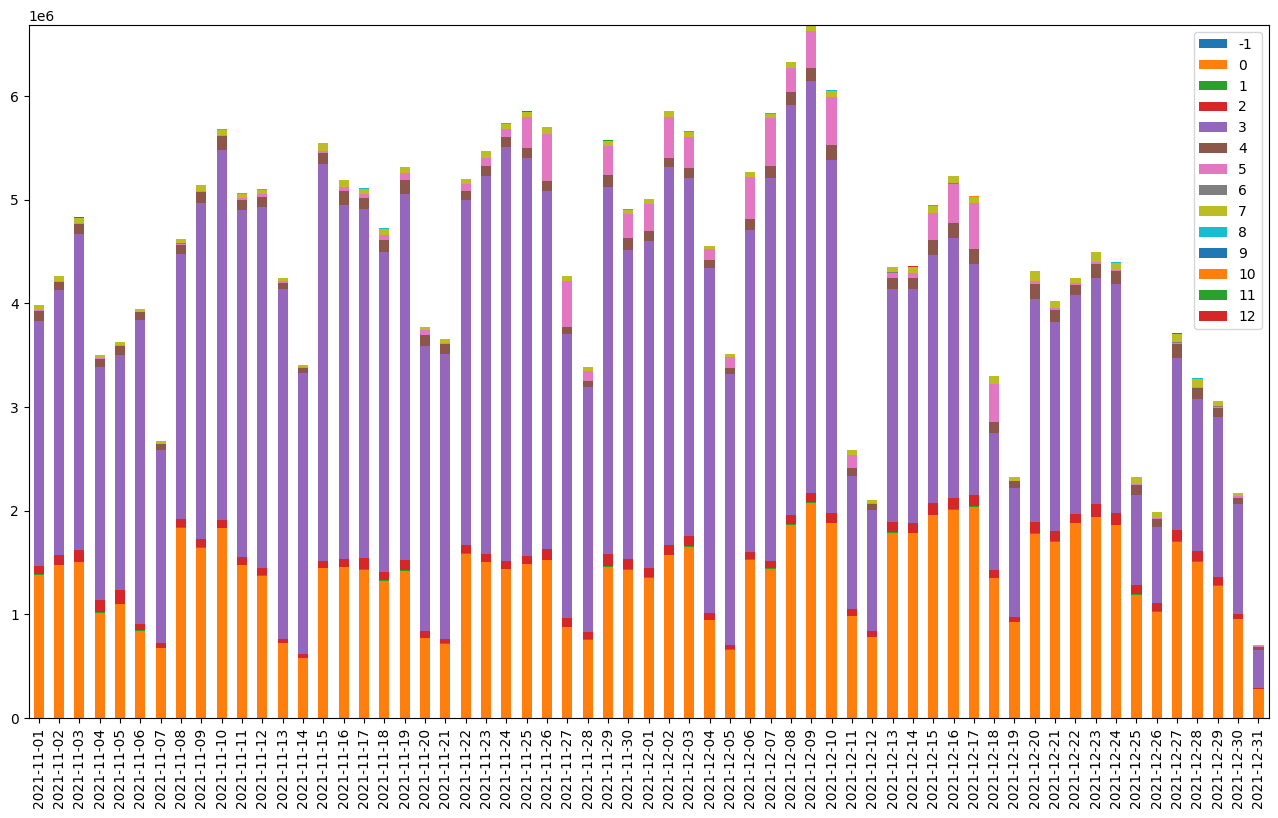

In [85]:
fig, ax = plt.subplots()

tz.plot(kind='bar', ax=ax, figsize=(16, 9), stacked=True)
ax.set_xticklabels(tz.index.format())

plt.show()

### duration

### forward

In [8]:
fwd = pd.DataFrame(index=[0, 1])
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = pd.read_csv(data_path, usecols=['forward'], dtype={'forward': 'uint32'})
    fwd[date] = call_transactions['forward'].value_counts()
fwd = fwd.transpose()

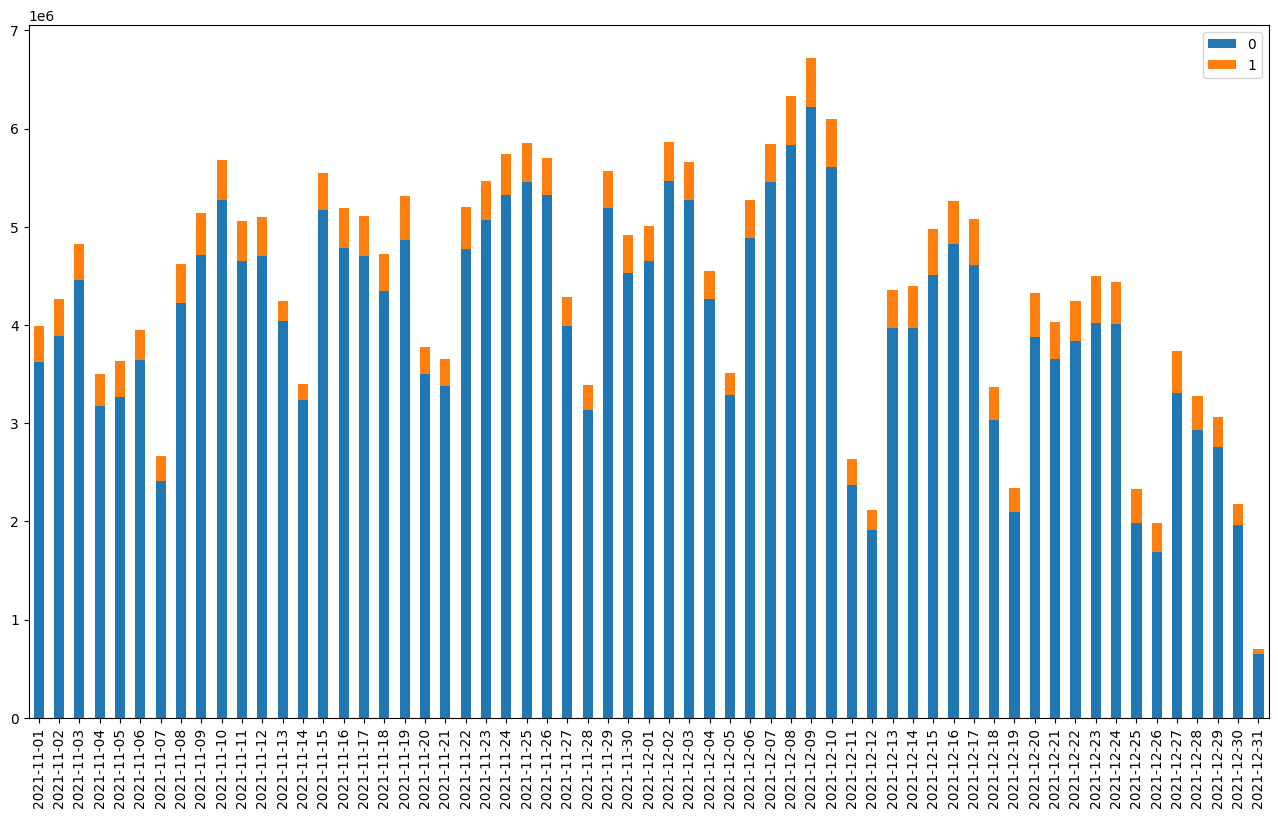

In [9]:
fig, ax = plt.subplots()

fwd.plot(kind='bar', ax=ax, figsize=(16, 9), stacked=True)
ax.set_xticklabels(fwd.index.format())

plt.show()

### zero_call_flg

In [11]:
zcf = pd.DataFrame(index=[0, 1, 2, 3, 4, 5])
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = pd.read_csv(data_path, usecols=['zero_call_flg'], dtype={'zero_call_flg': 'uint32'})
    zcf[date] = call_transactions['zero_call_flg'].value_counts()
zcf = zcf.transpose()

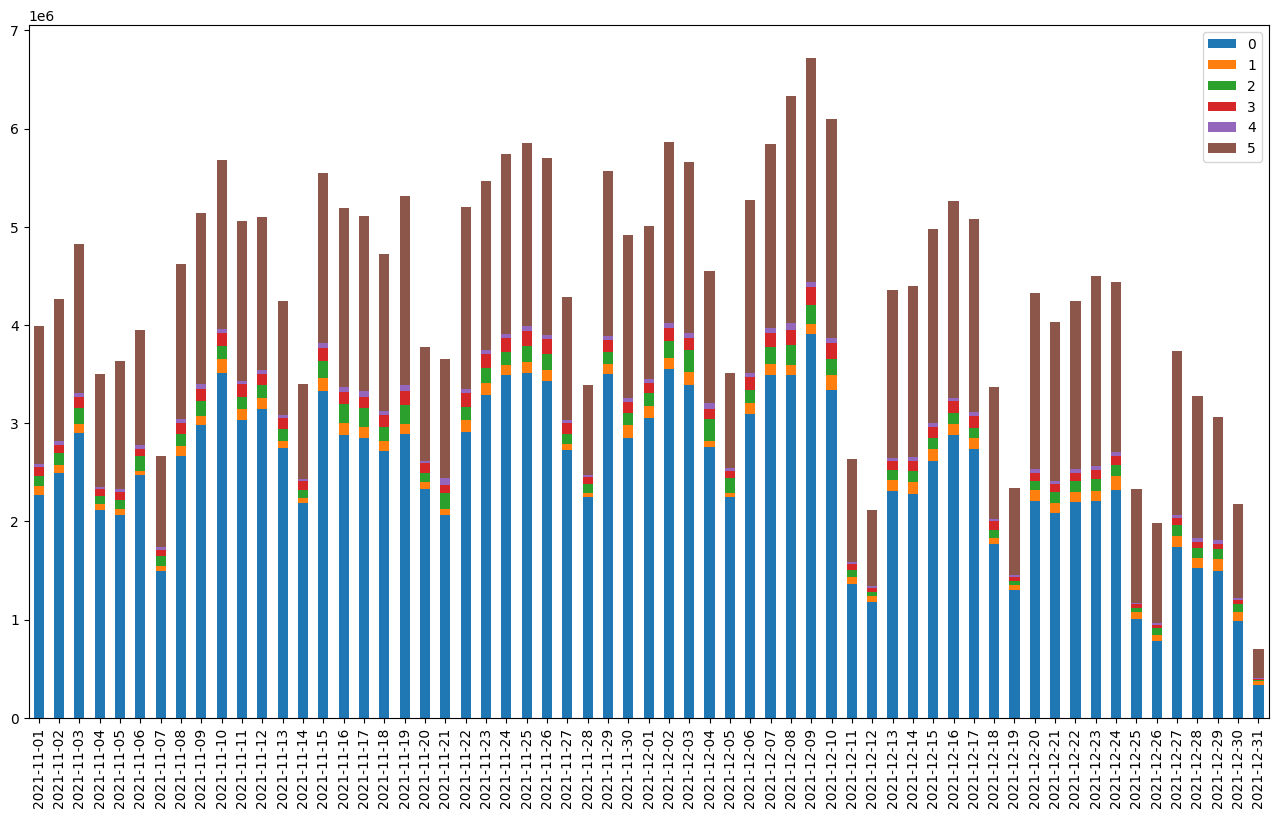

In [12]:
fig, ax = plt.subplots()

zcf.plot(kind='bar', ax=ax, figsize=(16, 9), stacked=True)
ax.set_xticklabels(zcf.index.format())

plt.show()

### source

In [13]:
src = pd.DataFrame(index=[0, 1])
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = pd.read_csv(data_path, usecols=['source_b'], dtype={'source_b': 'uint32'})
    src[date] = call_transactions['source_b'].value_counts()
src = src.transpose()
src.columns = ['source_f', 'source_b']

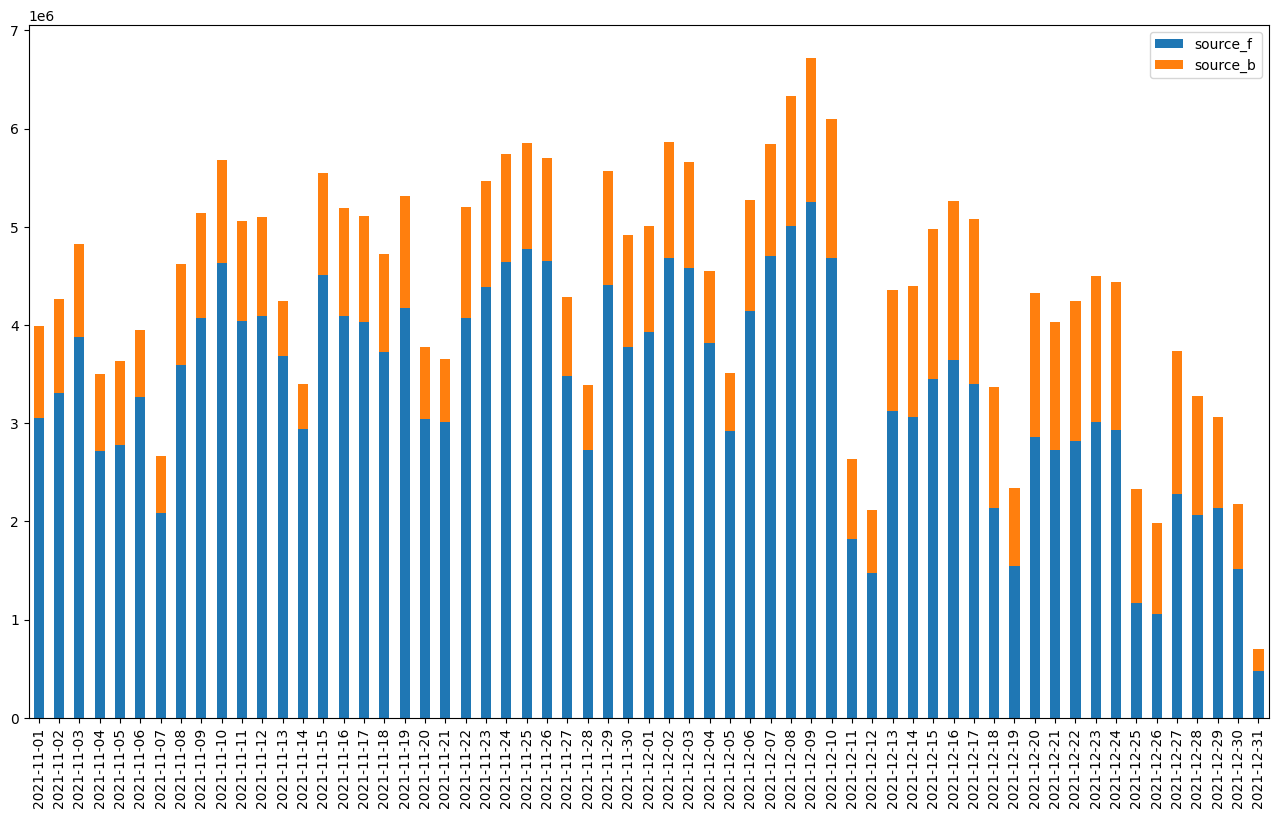

In [17]:
fig, ax = plt.subplots()

src.plot(kind='bar', ax=ax, figsize=(16, 9), stacked=True)
ax.set_xticklabels(src.index.format())

plt.show()

### num_b_length

In [19]:
nbl = pd.DataFrame(index=[10, 11, 12, 13, 14, 15, 16, 18, 19, 20])
for data_path in data_paths:
    date = pd.to_datetime(
        data_path.replace(os.path.join('data', 'transactions', 'time_key='), '').replace('.csv', '').replace('-', '.'),
        format='%Y-%m-%d',
    )
    call_transactions = pd.read_csv(data_path, usecols=['num_b_length'], dtype={'num_b_length': 'uint32'})
    nbl[date] = call_transactions['num_b_length'].value_counts()
nbl = nbl.transpose()

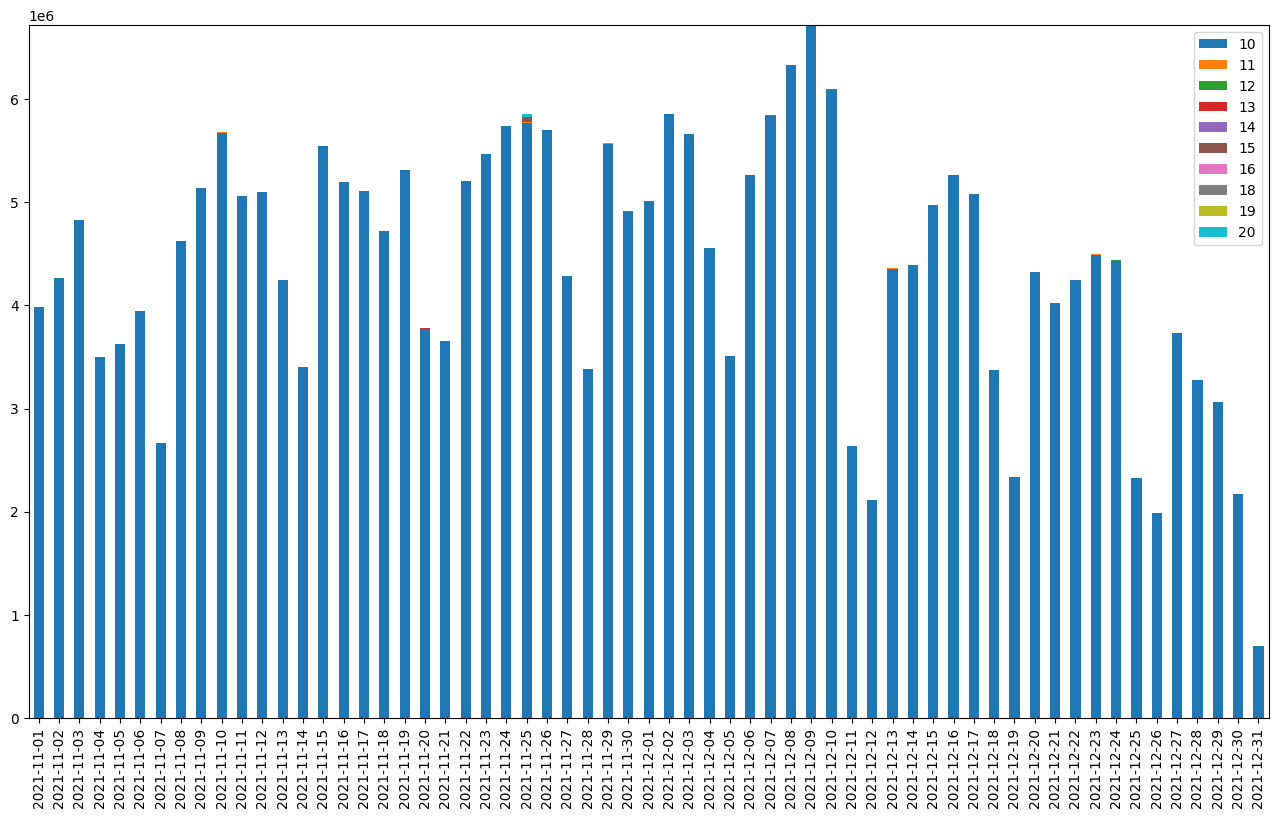

In [20]:
fig, ax = plt.subplots()

nbl.plot(kind='bar', ax=ax, figsize=(16, 9), stacked=True)
ax.set_xticklabels(nbl.index.format())

plt.show()